In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import sys

sys.path.append('../tools')

import os

import torch

import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import data_utility, annotation_utility
from models.rns_dataloader import *
from active_learning_utility import get_strategy
from active_learning_data import Data
from active_learning_net import Net
from copy import deepcopy
from models.SwaV import SwaV
from models.LSTMDownStream import SupervisedDownstream
import warnings
import pickle
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


In [3]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

import pytorch_lightning

pytorch_lightning.utilities.seed.seed_everything(seed=random_seed, workers=True)

Global seed set to 42


42

In [4]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'
rns_data_path = data_dir + 'rns_data'

In [5]:
strategy_name = 'EntropySampling'

In [6]:
nStart = 1
nEnd = 20
nQuery = 2

In [7]:
args_task = {'n_epoch': 60,
             'transform_train': True,
             'strategy_name': strategy_name,
             'transform': False,
             'loader_tr_args': {'batch_size': 4, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True},
             'loader_te_args': {'batch_size': 8, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True}
             }

In [8]:
# raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
# ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# # ids = list(np.unique(raw_annotations['HUP_ID']))
#
# data_import = data_utility.read_files(path=data_dir+'rns_data', path_data=data_dir+'rns_raw_cache', patientIDs=ids,
#                                       verbose=True)  # Import data with annotation

In [9]:
# data_list = os.listdir(data_dir+'rns_test_cache')
# print(data_list)
data_list = ['HUP047.npy', 'HUP084.npy', 'HUP096.npy', 'HUP109.npy', 'HUP121.npy', 'HUP129.npy', 'HUP131.npy',
             'HUP137.npy', 'HUP147.npy', 'HUP156.npy', 'HUP159.npy', 'HUP182.npy', 'HUP197.npy', 'HUP199.npy',
             'RNS026.npy', 'RNS029.npy']
# data_list = os.listdir(data_dir+'rns_test_cache')[1:]

# data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
# data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
train_data, train_label, test_data, test_label, train_index, test_index = get_data_by_episode(data_list, split=0.8)
# data, label,_,_ = get_data(data_list, split=1)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

16it [00:05,  3.14it/s]

(992,)
(992,)
(270,)
(270,)


In [10]:
X_train = np.concatenate(train_data)
y_train = np.concatenate(train_label)
X_test = np.concatenate(test_data)
y_test = np.concatenate(test_label)
index_train = np.concatenate(train_index)
index_test = np.concatenate(test_index)
seq_len_train = np.array([y.shape[0] for y in train_label])
seq_len_test = np.array([y.shape[0] for y in test_label])

In [11]:
n_pool = len(train_data)
n_test = len(test_data)

NUM_INIT_LB = int(nStart * n_pool / 100)
NUM_QUERY = int(nQuery * n_pool / 100) if nStart != 100 else 0
NUM_ROUND = int((int(nEnd * n_pool / 100) - NUM_INIT_LB) / NUM_QUERY) if nStart != 100 else 0
if NUM_QUERY != 0:
    if (int(nEnd * n_pool / 100) - NUM_INIT_LB) % NUM_QUERY != 0:
        NUM_ROUND += 1

print(NUM_INIT_LB)
print(NUM_QUERY)
print(NUM_ROUND)

9
19
10


In [12]:
dataset = Data(X_train, y_train, X_test, y_test, seq_len_train, seq_len_test, RNS_Active_by_episode_LSTM, args_task)

In [13]:
swav = SwaV().load_from_checkpoint(
    ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = SupervisedDownstream(swav.backbone)
# initialize model and save the model state
modelstate = deepcopy(model.state_dict())
device = "cuda" if torch.cuda.is_available() else "cpu"

net = Net(model, args_task, device, ckpt_folder_root='rns_active', log_folder_root='rns_active')

In [14]:
strategy = get_strategy(strategy_name, dataset, net, None, args_task, rns_data=True)

In [15]:
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     precision=16,)

strategy.net.trainer = trainer

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
import torch.nn as nn
import sklearn
for rd in range(10, NUM_ROUND + 1):
    print('round ' + str(rd))
    log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
        rd) + '/version_0/metrics.csv'
    logs = pd.read_csv(log_file_name)
    max_ind = logs['val_acc'].argmax()
    max_row = logs.iloc[max_ind]
    ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
    ckpt_files = os.listdir(ckpt_directory)
    load_file_name = strategy_name + '_round_' + str(rd) + '-step=' + str(int(max_row['step']+1))
    print(load_file_name)

    ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
    print(ind, ckpt_files[ind])
    strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)

    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
    # Load the content of the file into a Python object
        selected_inds = pickle.load(f)
    
    # selected_ind_list = []
    # for items in selected_inds.items():
    #     selected_ind_list.append(np.array(items[1]))
    q_idxs = np.array(selected_inds[rd])
    
    # with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
    #     pickle.dump(selected_inds, f)
# Now you can use the dictionary object as usual
    strategy.update(q_idxs)
    
    _, unlabeled_data = strategy.dataset.get_train_data_unaugmented()
    predictions = strategy.net.run_prediction(unlabeled_data)
    output_list = []
    seq_len_list = []
    target_list = []
    emb_list = []
    m = nn.Softmax(dim=1)
    for pred, y, emb, emb_t, seq_len in predictions:
        output_list.append(pred)
        seq_len_list.append(seq_len)
        target_list.append(y)
        emb_list.append(emb)

    target = torch.concat(target_list)
    emb = torch.vstack(emb_list)
    pred_raw = torch.vstack(output_list).float()
    seq_len_out = torch.tensor([item for sublist in seq_len_list for item in sublist])
    probs = m(pred_raw)
    out = torch.argmax(pred_raw, dim=1)
    unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
    f1_score = sklearn.metrics.f1_score(target[unlabeled_idxs],out[unlabeled_idxs])

    print(f1_score)

#     strategy.net.round = rd
#     strategy.net.net.load_state_dict(modelstate)
#     torch.cuda.empty_cache()
#     strategy.train()
#     torch.cuda.empty_cache()

round 10
EntropySampling_round_10-step=340
28 EntropySampling_round_10-step=340-train_loss=0.02179.ckpt


Missing logger folder: C:\Users\Patrick Xu\Desktop\RNS_Annotation-Pipeline\scripts\RNS_LITT_ANNOTATION_PIPELINE\model_explain\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

0.907883493249347


In [17]:
def get_continuous_data(data):
    return np.vstack([data[:,:,4].flatten(),data[:,:,13].flatten(),data[:,:,22].flatten(),data[:,:,31].flatten()])

In [18]:
def plot_high_light(label):
    label_start = np.where(np.diff(label) == 1)[0]
    label_end = np.where(np.diff(label) == -1)[0]
    label_start, label_end = check_consistent(label_start,label_end, len(label))
    return label_start, label_end

def check_consistent(start, end, total_len):
    if len(start) != len(end):
        if len(start)>0:
            end = [total_len]
        elif len(end)>0:
            start = [0]
    return start, end

In [19]:
def plot_data(data, label = None, dr=0.5):
    n_samples, n_rows = data.shape[1], data.shape[0]
    h, w = n_rows * 2, 10
    y_tick_offsets = (np.arange(n_rows) * dr)[::-1] 
    plt.figure(figsize=(w, h))
    ax = plt.axes()
    eeg_data = data + y_tick_offsets[:, np.newaxis]
    time_domain = np.repeat(np.arange(data.shape[1])[:,np.newaxis]/249,4,1)
    plt.plot(time_domain, eeg_data.T, 'k', linewidth=0.5)
    if label is not None:
        label_start, label_end= plot_high_light(label)
        if len(label_start)>0:
            for i in range(len(label_start)):
                print(label_start,label_end)
                plt.axvspan(label_start[i], label_end[i], color="yellow", alpha=0.3)
    
    plt.yticks(eeg_data.mean(1))
    ax.set_yticklabels(["Ch1", "Ch2", "Ch3", "Ch4"])
    plt.grid(axis='x')
    plt.xlabel('Time (s)')
    plt.show()

In [20]:
def combine_window_to_episode(data, seq_len, index=None):
    cum_sum_index = np.cumsum(seq_len)
    cum_sum_index = np.insert(cum_sum_index, 0, 0)

    assert len(data) == cum_sum_index[-1]

    data_out = [None] * (len(cum_sum_index) - 1)

    for i in range(1, len(cum_sum_index)):
        start_index, end_index = cum_sum_index[i - 1], cum_sum_index[i]
        episode_data = data[start_index:end_index]

        if index is None:
            out = episode_data
        else:
            episode_labeled = index[start_index:end_index]
            out = episode_data[episode_labeled]

        if len(out) > 0:
            data_out[i - 1] = out

    data_out = [segment for segment in data_out if segment is not None]

    return np.array(data_out, dtype=object)

In [21]:
def reconstruct_array(data):
    fs = 249
    center_ind = [4,13,22,31]
    empty_reconstruct = np.zeros((int(data.shape[1]/fs),fs,36))
    
    for i, ci in enumerate(center_ind):
        empty_reconstruct[:,:,ci] = data[i].reshape(-1,fs)
        for j in [-1, -2, -3, -4]:
            empty_reconstruct[:,:,ci+j] = np.vstack([empty_reconstruct[:,:,ci+j+1][0],empty_reconstruct[:,:,ci+j+1][:-1]])
        for k in [1, 2, 3, 4]:
            empty_reconstruct[:,:,ci+k] = np.vstack([empty_reconstruct[:,:,ci+k-1][1:], empty_reconstruct[:,:,ci+k-1][-1]])
    return empty_reconstruct

                                          

In [22]:
import skimage

def to_rgb(data):
    return skimage.color.gray2rgb(data)
def to_gray(data):
    return skimage.color.rgb2gray(data)

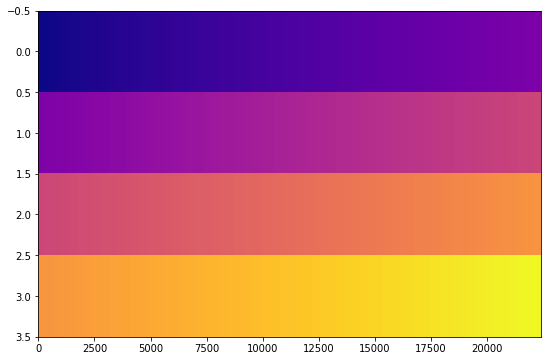

In [47]:
def superpixel(image, size=(1, 83)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

super_pixel_segments = superpixel(to_rgb(get_continuous_data(train_data[-4])))
plt.figure(figsize=(9, 6))
plt.imshow(super_pixel_segments,interpolation='nearest',aspect='auto', cmap='plasma')
plt.show()

In [24]:
super_pixel_segments

array([[  0.,   0.,   0., ...,  29.,  29.,  29.],
       [ 30.,  30.,  30., ...,  59.,  59.,  59.],
       [ 60.,  60.,  60., ...,  89.,  89.,  89.],
       [ 90.,  90.,  90., ..., 119., 119., 119.]])

In [25]:
train_data = unlabeled_data.data
train_label = unlabeled_data.label
pred_label = combine_window_to_episode(out,seq_len_out)

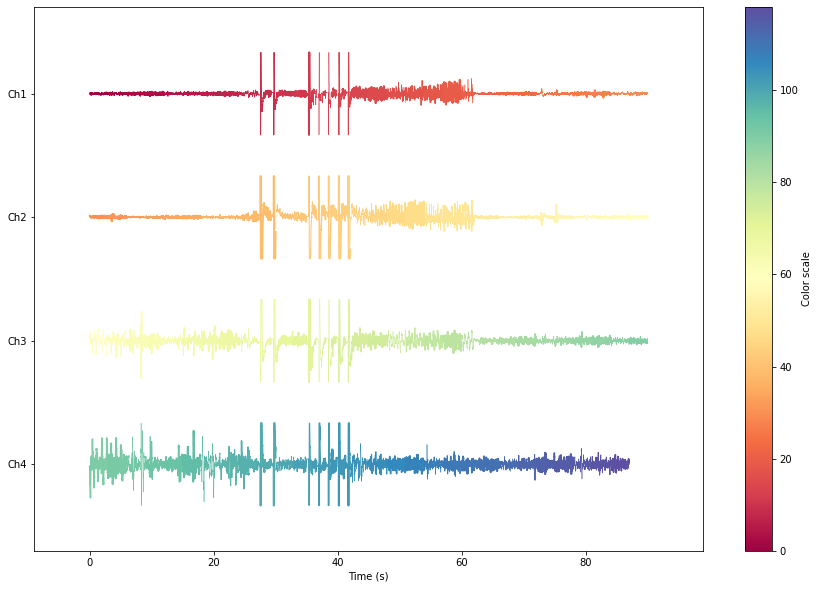

In [26]:
data = get_continuous_data(train_data[-4])
n_samples, n_rows = data.shape[1], data.shape[0]
h, w = n_rows * 2.5, 15
dr = 1.5  # Define dr if it's not defined
y_tick_offsets = (np.arange(n_rows) * dr)[::-1] 
fig, ax = plt.subplots(figsize=(w, h))
eeg_data = data + y_tick_offsets[:, np.newaxis]
time_domain = np.repeat(np.arange(data.shape[1])[:, np.newaxis] / 249, 4, 1)

# Assume 'super_pixel_segments' and 'x' are predefined arrays
segs = [np.column_stack([time_domain.T[super_pixel_segments == i], eeg_data[super_pixel_segments == i]]) for i in range(int(super_pixel_segments.max()))]
line_segments = LineCollection(segs, array=np.arange(int(super_pixel_segments.max())), linewidths=(0.5, 1, 1.5, 2), cmap='Spectral', linestyles='solid')
ax.add_collection(line_segments)
ax.autoscale()
ax.margins(0.1)
ax.set_yticks(eeg_data.mean(axis=1))
ax.set_yticklabels(["Ch1", "Ch2", "Ch3", "Ch4"])
ax.set_xlabel('Time (s)')

# If label is defined and needed for highlighting specific regions
# if label is not None:
#     label_start, label_end = plot_high_light(label)
#     if len(label_start) > 0:
#         for i in range(len(label_start)):
#             ax.axvspan(label_start[i], label_end[i], color="yellow", alpha=0.3)

plt.colorbar(line_segments, ax=ax, orientation='vertical', label='Color scale')
plt.show()

[32] [65]


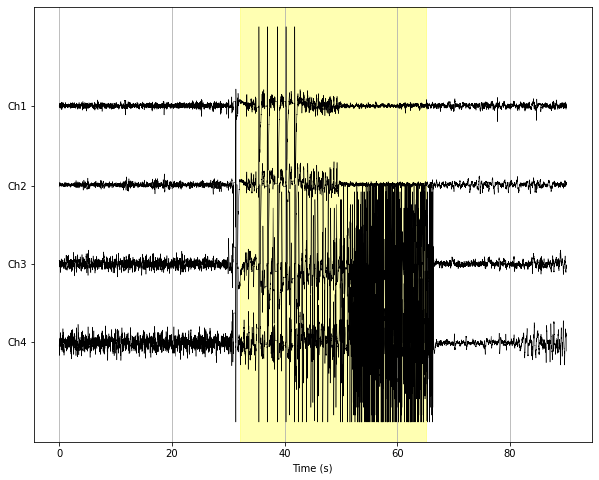

In [27]:
sample_id = -5
plot_data(get_continuous_data(train_data[sample_id]),train_label[sample_id])

In [28]:
train_data[sample_id].shape

(90, 249, 36)

In [29]:
train_label[sample_id]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [30]:
def process(data_arr):
    data_arr = reconstruct_array(to_gray(data_arr))
    data_arr_out = []
    totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.ToTensor()
            ])
    concat_len = data_arr[0].shape[1] / 4
    channel_index = np.arange(4)
    channel_index = channel_index * concat_len + (concat_len - 1) / 2
    channel_index = np.repeat(channel_index, concat_len)
    concate_len_1 = (concat_len - 1) / 2
    a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
    base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
    channel_index = channel_index + base_repeat
    
    for i, data in enumerate(data_arr):
        data = data[channel_index.astype(int)]
        data = torch.from_numpy(data).clone()
        data = data.repeat(3, 1, 1)
        data = totensor(data)
        data_arr_out.append(data)
    
    data_arr_out = torch.stack(data_arr_out)
    return data_arr_out

In [31]:
import torch.nn.functional as F
def batch_predict(images, index = (0,90)):
    
    start_index, end_index = index[0],index[1]
    strategy.net.net.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    strategy.net.net.backbone.to(device)
    strategy.net.net.to(device)
    strategy.net.net.set_requires_grad(strategy.net.net.backbone, False)
    
    dataset = torch.utils.data.TensorDataset(torch.tensor(images), torch.zeros(len(images)))
    loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)
    
    with torch.no_grad():
        probs_list = []
        for i, (sample, _) in enumerate(loader):
            batch_seperated = tuple(process(i) for i in sample)
            batch = torch.concat(batch_seperated, dim=0)
            batch = batch.to(device)
            seq_len = [dt.size(0) for dt in batch_seperated]
            pred_test ,_,_ = strategy.net.net(batch, seq_len)
            probs = F.softmax(pred_test, dim=1).detach().cpu().numpy()
            probs_combined = combine_window_to_episode(probs, seq_len)
            # print(probs_combined[:,index:index+2].shape)
            probs_selected = probs_combined[:,start_index:end_index,1]
            probs_list.append(probs_selected)
    probs_selected = np.concatenate(probs_list)
    return probs_selected

def batch_predict_anchor(images, index = 50):
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    strategy.net.net.backbone.to(device)
    strategy.net.net.to(device)
    batch = process(images)
    # batch = torch.concat(batch_seperated, dim=0)
    batch = batch.to(device)
    seq_len = [dt.size(0) for dt in batch.unsqueeze(0)]
    
    pred_test ,_,_ = strategy.net.net(batch, seq_len)
    probs = F.softmax(pred_test, dim=1).detach().cpu().numpy()
    probs_combined = combine_window_to_episode(probs, seq_len)
    probs_selected = probs_combined[:,index]
    return probs_selected

In [32]:
def get_label_start_stop(label):
    pos_label_index = np.where(label==1)[0]
    return (pos_label_index.min(),pos_label_index.max())
get_label_start_stop(train_label[sample_id])

(33, 65)

In [35]:
raw_annotations = pd.read_csv('../../../user_data/full_updated_anns_annotTbl_cleaned.csv')
ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# ids = list(np.unique(raw_annotations['HUP_ID']))
ids

['HUP047',
 'HUP084',
 'HUP096',
 'HUP109',
 'HUP121',
 'HUP129',
 'HUP131',
 'HUP137',
 'HUP147',
 'HUP153',
 'HUP156',
 'HUP159',
 'HUP182',
 'HUP197',
 'HUP199',
 'HUP205',
 'RNS026',
 'RNS029']

In [36]:
data = data_utility.read_files(path = rns_data_path,patientIDs = ids,verbose = True)

100%|██████████| 18/18 [00:37<00:00,  2.08s/it]


In [38]:
annotations = annotation_utility.read_annotation(annotation_path='../../../user_data/full_updated_anns_annotTbl_cleaned.csv',data=data, n_class=3)

In [44]:
annots = annotations.annotations


'1101'

In [46]:
file_names = os.listdir('save')
print(file_names)

['105.npy', '107.npy', '109.npy', '110.npy', '113.npy', '115.npy', '116.npy', '127.npy', '128.npy', '130.npy', '132.npy', '133.npy', '135.npy', '136.npy', '139.npy', '140.npy', '141.npy', '143.npy', '150.npy', '162.npy', '168.npy', '169.npy', '171.npy', '172.npy', '173.npy', '174.npy', '175.npy', '176.npy', '177.npy', '178.npy', '179.npy', '180.npy', '181.npy', '182.npy', '183.npy', '184.npy', '185.npy', '186.npy', '187.npy', '188.npy', '189.npy', '190.npy', '191.npy', '192.npy', '193.npy', '194.npy', '195.npy', '197.npy', '198.npy', '203.npy', '204.npy', '206.npy', '207.npy', '208.npy', '209.npy', '210.npy', '211.npy', '212.npy', '213.npy', '214.npy', '215.npy', '217.npy', '218.npy', '220.npy', '221.npy', '222.npy', '223.npy', '224.npy', '226.npy', '230.npy', '231.npy', '232.npy', '233.npy', '236.npy', '237.npy', '239.npy', '241.npy', '242.npy', '243.npy', '244.npy', '245.npy', '246.npy', '247.npy', '248.npy', '249.npy', '250.npy', '252.npy', '253.npy', '254.npy', '255.npy', '256.npy'

In [61]:
j = 1

kernel_data = []
channel_label = []

for file_name in tqdm(file_names):
# file_name = file_names[j]
    try:
        sample_id = int(file_name.split('.')[0])
        sample_kernel = np.load('save/' + file_name,allow_pickle=True).item()
        sample_kernel.keys()
        
        super_pixel_segments = superpixel(to_rgb(get_continuous_data(train_data[sample_id])))
        cum_kernel_values = np.zeros(int(super_pixel_segments.max())+1)
        for i in range(len(sample_kernel['top_labels'])):
            exp_kernel_value = np.vstack(sample_kernel['kernel'][i])
            for sample in range(sample_kernel['kernel'].shape[1]):
                sorted_kernel = exp_kernel_value[np.argsort(exp_kernel_value[:,0])]
                cum_kernel_values[sample] = sorted_kernel[sorted_kernel[:,0] == sample][0,1]
        
        label_id = train_index[sample_id][0]['episode_index']
        clb = torch.tensor([int(char) for char in annots.loc[label_id]['Channel_Code'][0]])
        dt = cum_kernel_values.reshape(4,-1)
        kernel_data.append(dt)
        channel_label.append(clb)
    except:
        continue


100%|██████████| 361/361 [07:48<00:00,  1.30s/it]


In [76]:
max_columns = max(arr.shape[1] for arr in kernel_data)
max_columns

270

In [77]:
padded_arrays = [np.pad(arr, ((0, 0), (0, max_columns - arr.shape[1])), mode='constant', constant_values=0) for arr in kernel_data]

In [79]:
len(padded_arrays)

354

In [80]:
array_object = np.stack(padded_arrays)

# Save to file
np.save('kernel_data.npy', array_object)

In [82]:
array_label = np.array([ar.numpy() for ar in channel_label])
np.save('channel_label.npy', array_label)

In [58]:
sample_kernel['kernel'].shape

(21, 1080, 2)

In [59]:
dt.shape

(4, 270)

1921

In [ ]:
test_sample = to_rgb(get_continuous_data(train_data[sample_id]))
test_sample_list = [test_sample,test_sample,test_sample,test_sample]
batch_predict(test_sample_list, index=(30,34))

In [ ]:
from skimage import segmentation
from lime import lime_image
# for sample_id in np.arange(992)[torch.tensor([np.sign(tl.sum()).to(bool) for tl in pred_label])]:
sample_id = -4
explainer = lime_image.LimeImageExplainer(random_state=42)

explanation = explainer.explain_instance(np.array(to_rgb(get_continuous_data(train_data[sample_id]))),
                                         lambda x: batch_predict(x, index=get_label_start_stop(pred_label[sample_id])),
                                         top_labels=get_label_start_stop(pred_label[sample_id])[1] -
                                                    get_label_start_stop(pred_label[sample_id])[0],
                                         batch_size=8,
                                         segmentation_fn=superpixel,
                                         num_samples=500,
                                         # num_features=50,
                                         random_seed=42)


kernel_value_arr = []
mask_array = []
for i in range(len(explanation.top_labels)):
    exp_kernel_value = np.vstack(explanation.local_exp[i])
    _, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=250, hide_rest=False)
    kernel_value_arr.append(exp_kernel_value)
    mask_array.append(mask)

# kernel_value_arr= np.stack(kernel_value_arr)
# mask_array = np.stack(mask_array)
# to_save = {}
# to_save['kernel'] = kernel_value_arr
# to_save['mask'] = mask_array
# to_save['top_labels'] = explanation.top_labels
# 
# np.save('save/' + str(sample_id)+'.npy',to_save)
 

In [ ]:
kernel_value_arr= np.stack(kernel_value_arr)
mask_array = np.stack(mask_array)
sample_kernel = {}
sample_kernel['kernel'] = kernel_value_arr
sample_kernel['mask'] = mask_array
sample_kernel['top_labels'] = explanation.top_labels

In [ ]:
file_names = os.listdir('save_1s')


In [ ]:
len(file_names)

In [ ]:
for j in range(0,72):
    file_name = file_names[j]
    sample_id = int(file_name.split('.')[0])
    sample_kernel = np.load('save_1s/' + file_name,allow_pickle=True).item()
    sample_kernel.keys()
    
    super_pixel_segments = superpixel(to_rgb(get_continuous_data(train_data[sample_id])))
    cum_kernel_values = np.zeros(int(super_pixel_segments.max()))
    for i in range(len(sample_kernel['top_labels'])):
        exp_kernel_value = np.vstack(sample_kernel['kernel'][i])
        mask = sample_kernel['mask'][i]
        for sample in np.unique(super_pixel_segments[mask.astype(bool)]).astype(int):
            sorted_kernel = exp_kernel_value[np.argsort(exp_kernel_value[:,0])]
            cum_kernel_values[sample-1] = sorted_kernel[sorted_kernel[:,0] == sample][0,1]
    
    # sample_id = -4
    data = get_continuous_data(train_data[sample_id])
    n_samples, n_rows = data.shape[1], data.shape[0]
    h, w = n_rows * 1.5, 10
    dr = 0.5  # Define dr if it's not defined
    y_tick_offsets = (np.arange(n_rows) * dr)[::-1] 
    fig, ax = plt.subplots(figsize=(w, h))
    eeg_data = data + y_tick_offsets[:, np.newaxis]
    time_domain = np.repeat(np.arange(data.shape[1])[:, np.newaxis] / 249, 4, 1)
    
    # Assume 'super_pixel_segments' and 'x' are predefined arrays
    segs = [np.column_stack([time_domain.T[super_pixel_segments == i+j], eeg_data[super_pixel_segments == i+j]]) for i in np.argsort(cum_kernel_values)[::-1][:15] for j in [0]]
    line_segments = LineCollection(segs, array=np.arange(int(10)), linewidths=(0.5, 1, 1.5, 2), cmap = 'Wistia', linestyles='solid')
    
    ax.plot(time_domain, eeg_data.T, 'k', linewidth=0.5)
    ax.add_collection(line_segments)
    
    
    ax.autoscale()
    ax.margins(0.1)
    ax.set_yticks(eeg_data.mean(axis=1))
    ax.set_yticklabels(["Ch1", "Ch2", "Ch3", "Ch4"])
    ax.xaxis.grid(True)
    ax.set_xlabel('Time (s)')
    
    # If label is defined and needed for highlighting specific regions
    # if label is not None:
    #     label_start, label_end = plot_high_light(label)
    #     if len(label_start) > 0:
    #         for i in range(len(label_start)):
    #             ax.axvspan(label_start[i], label_end[i], color="yellow", alpha=0.3)
    
    
    ax.axvspan(get_label_start_stop(pred_label[sample_id])[0],get_label_start_stop(pred_label[sample_id])[1], color="blue", alpha=0.3)
    
    plt.colorbar(line_segments, ax=ax, orientation='vertical', label='Order of Importance')
    plt.show()

In [ ]:
np.sort(cum_kernel_values)[::-1]

In [ ]:
ind =  explanation.top_labels[4]
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', aspect='auto')
plt.colorbar()

In [ ]:
np.unique(super_pixel_segments[mask.astype(bool)]).astype(int)

In [ ]:
np.sum(cum_kernel_values.reshape(4,-1),axis = 1)

In [ ]:
cum_kernel_values.reshape(4,-1)[:, 40:54]

In [ ]:
np.unique(super_pixel_segments[mask.astype(bool)]).astype(int)

In [ ]:
np.arange(100)[get_label_start_stop(pred_label[sample_id])[0]:get_label_start_stop(pred_label[sample_id])[1]]

In [ ]:
get_label_start_stop(pred_label[sample_id])

In [ ]:
explanation.local_exp.keys()

In [ ]:
pred_label[sample_id]

In [ ]:
kernel_value_arr = []
mask_array = []

for i in range(len(explanation.top_labels)):
    exp_kernel_value = np.vstack(explanation.local_exp[i])
    _, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=250, hide_rest=False)
    kernel_value_arr.append(exp_kernel_value)
    mask_array.append(mask)

kernel_value_arr= np.stack(kernel_value_arr)
mask_array = np.stack(mask_array)

In [ ]:
kernel_value_arr.shape

In [ ]:
explanation

In [ ]:
to_rgb(get_continuous_data(train_data[-4])).shape

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
dir(explanation)

In [ ]:
len(explanation.top_labels)

In [ ]:
len(explanation.local_exp[9])

In [ ]:
np.sort(cum_kernel_values)[::-1][:100]

In [ ]:
cum_kernel_values[]

In [ ]:
exp_kernel_value[np.argsort(exp_kernel_value[:,0])][np.unique(super_pixel_segments[mask.astype(bool)]).astype(int)]

In [ ]:
np.sort(cum_kernel_values)[::-1][:100]

In [ ]:
get_label_start_stop(pred_label[sample_id])

In [ ]:
exp_kernel_value = np.vstack(explanation.local_exp[1])

In [ ]:
exp_kernel_value[np.argsort(exp_kernel_value[:,0])][np.unique(super_pixel_segments[mask.astype(bool)]).astype(int)]

In [ ]:
print(np.argsort(exp_kernel_value[:,0]))

In [ ]:
len(np.where(pred_label[-4]==1)[0])

In [ ]:

from alibi.explainers import AnchorImage
explainer = AnchorImage(batch_predict, (4, 22410, 3), segmentation_fn=superpixel,
                        images_background=None)

In [ ]:
image = to_rgb(get_continuous_data(train_data[-4]))
print(image.shape)

In [ ]:
explanation = explainer.explain(image,threshold= 0.8, stop_on_first = True)

In [ ]:
plt.imshow(explanation.anchor,aspect='auto')

In [ ]:
plt.imshow(explanation.segments,aspect='auto');

In [ ]:
explanation.anchor

In [ ]:
explanation.anchor.shape

In [ ]:
explanation.anchor.max()

In [ ]:
print(mask.max())

In [ ]:
[dt.size(0) for dt in images]

In [ ]:

combine_window_to_episode(F.softmax(pred_test, dim=1).detach().cpu().numpy(), [dt.size(0) for dt in images])[:,ind]


In [ ]:
torch.concat(tuple(i for i in images), dim=0).shape

In [ ]:
pred_test

In [ ]:
rgb = to_rgb(get_continuous_data(train_data[-4]))

In [ ]:
np.array_equal(rgb[0], rgb[1])

In [ ]:
torch.nn.functional.mse_loss(pred_test.detach().cpu(),combine_window_to_episode(pred_raw,seq_len_out)[-4])

In [ ]:
pred_test.detach().cpu().shape

In [ ]:
combine_window_to_episode(pred_raw,seq_len_out)[-4].shape

In [ ]:
unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()

In [ ]:
clf_report = sklearn.metrics.classification_report(target[unlabeled_idxs],out[unlabeled_idxs], digits=6)

print(f"Classification Report : \n{clf_report}")

In [ ]:
clf_report = sklearn.metrics.classification_report([np.sign(tl.sum()) for tl in pred_label], [np.sign(tl.sum()) for tl in train_label], digits=6)

print(f"Classification Report : \n{clf_report}")